Import the required libraries

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
#from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
import pandas as pd


import random
import math
import time

import gzip
import shutil
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

set a seed to enable repeatability of model operation

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
!pip install spacy --upgrade

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)


### download the spacy english vocabulary 

In [3]:
%%bash
python -m spacy download en


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-06-17 07:51:33.367512: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


restart the notebook before running this step

In [4]:
spacy_en = spacy.load('en_core_web_sm')


### helper function to tokenize english sentence

In [5]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Unpack the question answer zip file

In [6]:
shutil.unpack_archive('/content/Question_Answer_Dataset_v1.2.tar.gz', '/content')

### Walk through the unpacked folders

* find **question_answer_pairs.txt** file
* there are 6 columns in the file
   * ArticleTitle
   * Question
   * Answer 
   * Q_Difficulty
   * A_Difficulty 
   * ArticleFile
* load the tab separated tokens to a dataframe

In [7]:
column_names = ["ArticleTitle", "Question", "Answer", "Q_Difficulty", "A_Difficulty", "ArticleFile"]

title = []
qstn = []
answ = []
q_difclty = []
a_difclty = []
afile = []

for root, dirs, files in os.walk('/content'):
  if 'question_answer_pairs.txt' in files:
    print('found ',files , os.path.join(root,'question_answer_pairs.txt'))

    with open(os.path.join(root,'question_answer_pairs.txt'), 'r' ,errors='ignore', encoding='cp1252') as f_out:
        i = 0
        j = 0
        for line in f_out.readlines():
          if i == 0:
            i += 1
            continue

          tok = re.split(r'\t',line)
          
          if len(tok ) == 6:
            title.append(tok[0].strip())
            qstn.append(tok[1].strip())
            answ.append(tok[2].strip())
            q_difclty.append(tok[3].strip())
            a_difclty.append(tok[4].strip())
            afile.append(tok[5].strip())

assert len(title) == len(qstn) == len (answ) == len(q_difclty) == len(a_difclty) == len(afile)
 
q_aDF = pd.DataFrame(columns = column_names)

q_aDF["ArticleTitle"] = title
q_aDF["Question"] = qstn
q_aDF["Answer"] = answ
q_aDF["Q_Difficulty"] = q_difclty
q_aDF["A_Difficulty"] = a_difclty
q_aDF["ArticleFile"] = afile

q_aDF.head()


found  ['question_answer_pairs.txt'] /content/Question_Answer_Dataset_v1.2/S08/question_answer_pairs.txt
found  ['question_answer_pairs.txt'] /content/Question_Answer_Dataset_v1.2/S09/question_answer_pairs.txt
found  ['question_answer_pairs.txt'] /content/Question_Answer_Dataset_v1.2/S10/question_answer_pairs.txt


,ArticleTitle,Question,Answer,Q_Difficulty,A_Difficulty,ArticleFile
0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,data/set3/a4
1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,data/set3/a4
2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,data/set3/a4
3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,data/set3/a4
4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,data/set3/a4


### drop rows from the dataframe where answer is NULL

In [8]:
notnull_answerDF = q_aDF[q_aDF['Answer'] != 'NULL']
len(notnull_answerDF  )

3424

### Create a new dataframe object with only 2 columns 

* Question
* Answer

In [9]:
data=[notnull_answerDF['Question'],notnull_answerDF['Answer']]

headers = ["Question", "Answer"]

qa_data = pd.concat(data, axis=1, keys=headers)
qa_data.head()

,Question,Answer
0,Was Abraham Lincoln the sixteenth President of...,yes
1,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Did Lincoln sign the National Banking Act of 1...,yes
3,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Did his mother die of pneumonia?,no


### dump the dataframe to a file

In [10]:
qa_data.to_csv('qadata.tsv', sep = '\t', index=False)

### Upload the question and answer dataset and store in a dataframe


In [11]:
qadf = pd.read_csv("/content/qadata.tsv", sep='\t')

### Check if there are NaN in Answer

In [12]:
an = qadf [qadf.Answer.isnull() == True]
an

,Question,Answer
59,Can the title of this famous 1811 paper be rou...,NaN
60,What happened in french?,NaN
2599,When did concert flutes begin appearing in con...,NaN
3419,What areas do the Grevy's Zebras inhabit?,NaN


In [13]:
qadf.isna().any(axis=None)

True

### replace NaN with empty string

In [14]:
qadf = qadf.fillna('') #, inplace=True)

In [15]:
qadf.head()

,Question,Answer
0,Was Abraham Lincoln the sixteenth President of...,yes
1,Was Abraham Lincoln the sixteenth President of...,Yes.
2,Did Lincoln sign the National Banking Act of 1...,yes
3,Did Lincoln sign the National Banking Act of 1...,Yes.
4,Did his mother die of pneumonia?,no


### double check if there are anymore NaN in answer

In [16]:
an = qadf [qadf.Answer.isnull() == True]
an

,Question,Answer


### Create torchtext.legacy.data Field object for source question and target answer

In [17]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>') #, 
            #lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>') #, 
            #lower = True)

The fields created above are mapped from column headers

| Column header | Variable name |
| --- | --- |
| **question** | SRC |
| **answer** | TRG |

In [18]:
fields = [('question', SRC), ('answer', TRG)]

#### torchtext example object is created from the dataframe object

* using 2 columns from dataframe - question1 , question2
* column header created above

In [19]:
example = [torchtext.legacy.data.Example.fromlist([qadf.Question[i],qadf.Answer[i]], fields) for i in range(qadf.shape[0])] 

#### torchtext dataset is created

* using example and column header created above

In [20]:
qaDataset = torchtext.legacy.data.Dataset(example, fields)

### The dataset is split into train and test in the raio of 70:30

In [21]:
(train, test) = qaDataset.split(split_ratio=[70, 30] , random_state = random.seed(SEED) )

a sample record from train dataset

In [22]:
vars(train.examples[15])

{'answer': ['Anders', 'Celsius'],
 'question': ['Who',
  'was',
  'the',
  'first',
  'to',
  'perform',
  'and',
  'publish',
  'careful',
  'experiments',
  'aiming',
  'at',
  'the',
  'definition',
  'of',
  'an',
  'international',
  'temperature',
  'scale',
  'on',
  'scientific',
  'grounds',
  '?']}

#### count of train and test dataset

* **2397** train records
* **1027** test records

In [23]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 2397
Number of testing examples: 1027


In [24]:
vars(train.examples[0])

{'answer': ['The',
  'city',
  "'s",
  'poverty',
  'rate',
  'is',
  '11.8',
  '%',
  'and',
  'the',
  'number',
  'of',
  'families',
  'in',
  'poverty',
  'stands',
  'at',
  '7.4',
  '%',
  ',',
  'both',
  'lower',
  'than',
  'the',
  'national',
  'average',
  '.'],
 'question': ['How',
  'does',
  'poverty',
  'in',
  'San',
  'Francisco',
  'compare',
  'to',
  'the',
  'nation',
  '-',
  'wide',
  'average',
  '?']}

### Build vocabulary of 

* train text for the SRC and TRG field

In [25]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [26]:
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (en) vocabulary: 2092
Unique tokens in target (en) vocabulary: 1304


### Dump the SRC and TRG vocabulary for later use

In [27]:
import os, pickle
with open('srctokenizer.pkl', 'wb') as srctokens: 
    pickle.dump(SRC.vocab.stoi, srctokens)

with open('trgtokenizer.pkl', 'wb') as trgtokens: 
    pickle.dump(TRG.vocab.stoi, trgtokens)    

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create train and test iterator using BucketIterator

* Sort key is set on question - the source

In [29]:
BATCH_SIZE = 128

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size = BATCH_SIZE, 
                                                            sort_key = lambda x: len(x.question),
                                                            sort_within_batch=True, device = device)




### Encoder class

There are 3 layers in the encoder

* Embedding layer which stores the vocabulary of question 1

* LSTM layer to process the sentence and return the hidden and cell state

* Dropout layer for regularization

In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder class

There are 4 layers in the decoder

* Embedding layer which stores the vocabulary of answer

* LSTM layer to process the TRG sentence and return the output

* Linear layer to process the output returned by LSTM and generate a 1D vector having the size of TRG vocabulary

* Dropout layer for regularization

This class returns 1D vector of prediction and the last hidden and cell state

In [31]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### seq2seq class

This is a wrapper class to call the encoder and decoder class 

* The source sentence is supplied to the encoder and the last hidden and cell state is returned.

* This becomes the initial input to the decoder

* In addition first word of the target sentence is passed to the decoder

* In later iterations one word at a time is supplied till the end of the sentence , previous hidden and cell state become input to the decoder.

* The output of each iteration is stored in an array

* In addition a threshhold limit is set to decide whether to pick the max from the output returned by the decoder or the next word of the sentence in the next iteration.

* The loop continues till the end

* The array of output is returned by the seq2seq model


In [32]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Initialize 

* the hyperparameters

* create encoder and decoder instance

* create instance of seq2seq model

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

### Initialize the weights

* apply the weights to the model

In [34]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(2092, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(1304, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=1304, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,894,744 trainable parameters


### create an instance of Adam optimizer

In [36]:
optimizer = optim.Adam(model.parameters())

### Create an instance of CrossEntropyLoss

In [37]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### utility function to train the model

* extract question 1 and question 2 from the batch object and pass it on to model

* reshape the output and calculate the loss between the predicted output question 2 and target question 2 

* aggregate the loss per epoch

* back propagate to adjust the model weights


In [38]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in iterator:
        
        src = batch.question #src
        trg = batch.answer #trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### utility function to evaluate the model

* set the model in evaluation mode and no back propagation

* extract question 1 and question 2 from the batch object and pass it on to model

* reshape the output and calculate the loss between the predicted output question 2 and target question 2 

* aggregate the loss per epoch

In [39]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for batch in iterator:

            src = batch.question # src
            trg = batch.answer #trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### run the model on train and test data for 5 epochs

the model was run for 10 epochs

* the best model weight was saved for evaluating the model


In [41]:
N_EPOCHS = 10
CLIP = 1
trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(math.exp(train_loss),2))
    valAccyList.append(round(math.exp(valid_loss),2))


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 2s
	Train Loss: 5.209 | Train PPL: 182.924
	 Val. Loss: 3.495 |  Val. PPL:  32.959
Epoch: 02 | Time: 0m 2s
	Train Loss: 4.421 | Train PPL:  83.178
	 Val. Loss: 3.496 |  Val. PPL:  32.995
Epoch: 03 | Time: 0m 2s
	Train Loss: 4.325 | Train PPL:  75.558
	 Val. Loss: 3.470 |  Val. PPL:  32.124
Epoch: 04 | Time: 0m 2s
	Train Loss: 4.283 | Train PPL:  72.432
	 Val. Loss: 3.409 |  Val. PPL:  30.237
Epoch: 05 | Time: 0m 2s
	Train Loss: 4.228 | Train PPL:  68.614
	 Val. Loss: 3.331 |  Val. PPL:  27.962
Epoch: 06 | Time: 0m 2s
	Train Loss: 4.045 | Train PPL:  57.100
	 Val. Loss: 3.287 |  Val. PPL:  26.757
Epoch: 07 | Time: 0m 2s
	Train Loss: 3.993 | Train PPL:  54.236
	 Val. Loss: 3.301 |  Val. PPL:  27.136
Epoch: 08 | Time: 0m 2s
	Train Loss: 3.958 | Train PPL:  52.352
	 Val. Loss: 3.290 |  Val. PPL:  26.847
Epoch: 09 | Time: 0m 2s
	Train Loss: 3.867 | Train PPL:  47.815
	 Val. Loss: 3.249 |  Val. PPL:  25.776
Epoch: 10 | Time: 0m 2s
	Train Loss: 3.859 | Train PPL:  47.398


### A graph of model performance 

1.   Training and testing PPL across different epochs
2.   Training and testing loss across different epochs



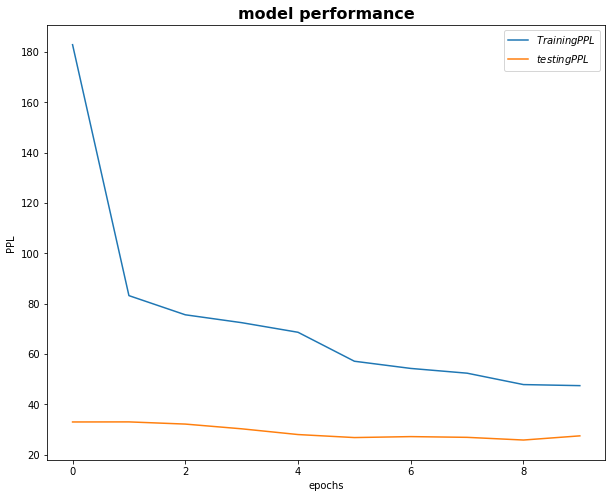

In [44]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training PPL $" )
plt.plot(xpoints, ypoints6, label = "$ testing PPL $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("PPL ")
plt.show()

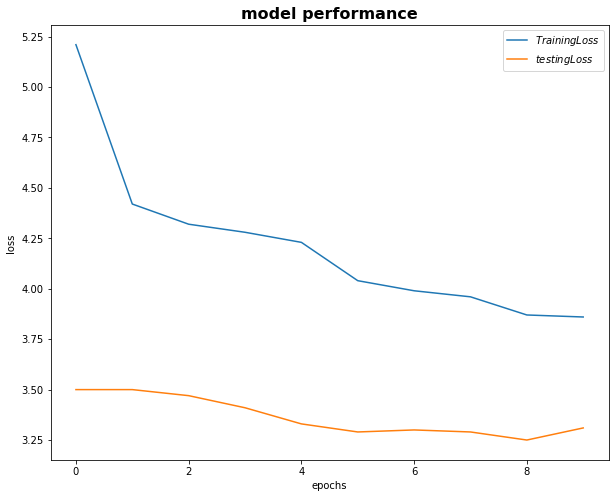

In [45]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ testing Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

In [46]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.249 | Test PPL:  25.776 |


### Utility function to test a single pair of Question and Answer

In [47]:
#load weights and tokenizer

#path='./saved_weights.pt'
#model.load_state_dict(torch.load(path));

model.eval();
srctokenizer_file = open('./srctokenizer.pkl', 'rb')
srctokenizer = pickle.load(srctokenizer_file)

trgtokenizer_file = open('./trgtokenizer.pkl', 'rb')
trgtokenizer = pickle.load(trgtokenizer_file)


#inference 
#categories = {0: "Negative", 1:"Positive", 2:"Neutral"}

import spacy
nlp = spacy.load('en_core_web_sm')

def answer_question(question , answer):
    
    
    
    # tokenize the tweet 
    srctokenized = [tok.text for tok in nlp.tokenizer(question)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    srcindexed = [srctokenizer[t] for t in srctokenized] 
    #print(indexed)       
    # compute no. of words        
    #length = [len(indexed)]
    # convert to tensor                                    
    srctensor = torch.LongTensor(srcindexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    srctensor = srctensor.unsqueeze(1).T  
    #print(tensor)

    # tokenize the tweet 
    trgtokenized = [tok.text for tok in nlp.tokenizer(answer)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    trgindexed = [trgtokenizer[t] for t in trgtokenized] 
    #print(indexed)       
    # compute no. of words        
    #length = [len(indexed)]
    # convert to tensor                                    
    trgtensor = torch.LongTensor(trgindexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    trgtensor = trgtensor.unsqueeze(1).T  



    # convert to tensor                          
    #length_tensor = torch.LongTensor(length)
    #print(length_tensor)
    # Get the model prediction                  
    prediction = model(srctensor, trgtensor)

    output_dim = prediction.shape[-1]
    print(output_dim , prediction.size())
            
    output = prediction.squeeze(0)
    #output = output.squeeze(0)

    _, pred = torch.max(output, 1) 
    #print(pred.size(),pred)
    
    return pred #.item()

In [48]:
qst = 'Does kelon increase or decrease tone quality of the xylophone?'
ans =  'reduce'
print(answer_question(qst , ans))

1304 torch.Size([1, 1, 1304])
tensor([0], device='cuda:0')
